In [1]:
# Core Library modules
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass, field  # Class decorator for adding special methods to classes.

# PyTorch and Deep Learning Libaries
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
from torch.nn import functional as F  # Functional module for defining functions and loss functions.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Data handling and batching
import torchvision  # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Image datasets and transformations.
import torchvision.datasets as datasets  # Specific datasets for vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
from torchvision.datasets import MNIST, EuroSAT  # Standard datasets.
import torchvision.transforms.functional as TF  # Functional transformations.
from torchvision.models import ResNet18_Weights  # ResNet-18 model with pretrained weights.
from torchsummary import summary  # Model summary.
import torchmetrics  # Model evaluation metrics.
from torchmetrics import MeanMetric, Accuracy  # Accuracy metrics.
from torchmetrics.classification import (
    MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy
)  # Classification metrics.
from torchviz import make_dot  # Model visualization.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for class imbalance.
from torchcam.methods import GradCAM  # Grad-CAM for model interpretability.
from torchcam.utils import overlay_mask  # Overlay mask for visualizations.
import pytorch_lightning as pl  # Training management.
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, Callback  # Callbacks.
from pytorch_lightning.loggers import TensorBoardLogger  # Logger for TensorBoard.

# Geospatial Data Processing Libraries
import rasterio  # Reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation.
from rasterio.enums import Resampling  # Resampling for raster resizing.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation, Analysis and Visualization Libraries
import pandas as pd  # Data analysis and manipulation.
import numpy as np  # Array operations and computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics.
import matplotlib.pyplot as plt  # Static and interactive plotting.
import seaborn as sns  # High-level interface for statistical graphics.

# Utility Libraries
from tqdm import tqdm  # Progress bar for loops.
from PIL import Image  # Image handling and manipulation.
import ast  # Parsing Python code.
import requests  # HTTP requests.
import zstandard as zstd  # Compression and decompression.
from collections import Counter  # Counting hashable objects.
import certifi  # Certificates for HTTPS.
import ssl  # Secure connections.
import urllib.request  # URL handling.
import kaggle  # Kaggle API for datasets.
from IPython.display import Image  # Display images in notebooks.
from pathlib import Path # File system path handling.
from typing import Dict, List, Tuple  # Type hints.
import sys  # System-specific parameters and functions.
import time # Time access and conversions.
import logging # Logging facility for Python.
import json # JSON encoder and decoder.
from torch.optim.lr_scheduler import ReduceLROnPlateau
from contextlib import redirect_stdout
import rasterio
from rasterio.plot import show
import numpy as np
import scipy.ndimage

# Custom Libraries

In [2]:
# Set seed for reproducibility
SEED = 42  
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.set_float32_matmul_precision('medium')

# Set environment variables
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "upb"


# Render plots
%matplotlib inline
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device} {'(GPU: ' + torch.cuda.get_device_name(0) + ')' if device.type == 'cuda' else ''}")

Device: cuda (GPU: NVIDIA GeForce RTX 3050)


In [3]:
def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to clean and parse labels from the metadata CSV
def clean_and_parse_labels(label_string):
    if isinstance(label_string, str):
        cleaned_labels = label_string.replace(" '", ", '").replace("[", "[").replace("]", "]")
        return ast.literal_eval(cleaned_labels)
    return label_string  

# Function to normalize class weights
def normalize_class_weights(class_weights):
    total_weight = sum(class_weights)
    return [weight / total_weight for weight in class_weights]

# Function to calculate class weights based on the label counts of each category
def calculate_class_weights(metadata_csv):
    metadata_csv['labels'] = metadata_csv['labels'].apply(clean_and_parse_labels)

    class_labels = calculate_class_labels(metadata_csv)

    label_counts = metadata_csv['labels'].explode().value_counts()
    total_counts = label_counts.sum()
    class_weights = {label: total_counts / count for label, count in label_counts.items()}
    class_weights_array = np.array([class_weights[label] for label in class_labels])

    # Normalize class weights
    normalized_class_weights = normalize_class_weights(class_weights_array)

    return class_weights, class_weights_array

# Function used to calculate the class labels within the metadata
def calculate_class_labels(metadata_csv):
    # Apply the cleaning and parsing function to the 'labels' column
    metadata_csv['labels'] = metadata_csv['labels'].apply(clean_and_parse_labels)

    # Initialize an empty set to collect unique class labels
    class_labels = set()
    for labels in metadata_csv['labels']:
        class_labels.update(labels)

    # Convert the set to a sorted list
    class_labels = sorted(class_labels)

    return class_labels

def decode_target(
    target: list,
    text_labels: bool = False,
    threshold: float = 0.4,
    cls_labels: dict = None,
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(cls_labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)


def get_band_indices(band_names, all_band_names):
    return [all_band_names.index(band) for band in band_names]


def get_labels_for_image(image_path, model, transform, patch_to_labels):
    # Load and preprocess the image
    with rasterio.open(image_path) as src:
        bands = [2, 3, 4]  # Bands to combine for display
        image = np.stack([src.read(band) for band in bands], axis=-1)
        image = transform(image).unsqueeze(0).to(model.device)  # Add batch dimension and move to device

    # Get the predicted labels
    model.eval()
    with torch.no_grad():
        preds = model(image).sigmoid() > 0.5  # Apply sigmoid and threshold at 0.5
        preds = preds.cpu().numpy().astype(int).flatten()

    # Get the true labels
    patch_id = os.path.basename(image_path).split('.')[0]
    true_labels = patch_to_labels[patch_id]

    return preds, true_labels, image

def display_image(image_path):
    with rasterio.open(image_path) as src:
        bands = [2, 3, 4]  # Bands to combine for display
        image = np.stack([src.read(band) for band in bands], axis=-1)
        plt.imshow(image)
        plt.title("Image with Bands 2, 3, and 4")
        plt.show()

def display_image_and_labels(image_path, model, transform, patch_to_labels):
    # Display the image
    display_image(image_path)

    # Get predicted and true labels
    preds, true_labels, _ = get_labels_for_image(image_path, model, transform, patch_to_labels)
    print(f"Predicted Labels: {preds}")
    print(f"True Labels: {true_labels}")

def extract_number(string):
    number_str = string.split('%')[0]
    try:
        number = float(number_str)
        if number.is_integer():
            return int(number)
        return number
    except ValueError:
        raise ValueError(f"Cannot extract a number from the string: {string}")
    

# Define the hook function
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [4]:
class BandNormalisation:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for i in range(image.shape[0]):
            image[i] = (image[i] - self.mean[i]) / self.std[i]
        return image
    
class BandUnnormalisation:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for i in range(image.shape[0]):
            image[i] = (image[i] * self.std[i]) + self.mean[i]
        return image
    
class ToTensor:
    def __call__(self, image):
        return torch.tensor(image, dtype=torch.float32)

In [5]:
# Description: Configuration file for the project
# Helper functions
def denormalize(tensors, *, mean, std):
    for c in range(12):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

def encode_label(label: list, num_classes=19):
    target = torch.zeros(num_classes)
    for l in label:
        if l in DatasetConfig.class_labels_dict:
            target[DatasetConfig.class_labels_dict[l]] = 1.0
    return target

@dataclass
class DatasetConfig:
    metadata_path = r"C:\\Users\\isaac\\Desktop\BigEarthTests\\50%_BigEarthNet\\metadata_50_percent.csv"
    dataset_paths = {
        "0.5": r"C:\Users\isaac\Desktop\BigEarthTests\0.5%_BigEarthNet\CombinedImages",
        "1": r"C:\Users\isaac\Desktop\BigEarthTests\1%_BigEarthNet\CombinedImages",
        "5": r"C:\Users\isaac\Desktop\BigEarthTests\5%_BigEarthNet\CombinedImages",
        "10": r"C:\Users\isaac\Desktop\BigEarthTests\10%_BigEarthNet\CombinedImages",
        "50": r"C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\CombinedImages",
        "100": r"C:\Users\isaac\Desktop\BigEarthTests\100%_BigEarthNet\CombinedImages"
    }
    metadata_paths = {
        "0.5": r"C:\Users\isaac\Desktop\BigEarthTests\0.5%_BigEarthNet\metadata_0.5_percent.csv",
        "1": r"C:\Users\isaac\Desktop\BigEarthTests\1%_BigEarthNet\metadata_1_percent.csv",
        "5": r"C:\Users\isaac\Desktop\BigEarthTests\5%_BigEarthNet\metadata_5_percent.csv",
        "10": r"C:\Users\isaac\Desktop\BigEarthTests\10%_BigEarthNet\metadata_10_percent.csv",
        "50": r"C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\metadata_50_percent.csv",
        "100": r"C:\Users\isaac\Desktop\BigEarthTests\100%_BigEarthNet\metadata_100_percent.csv"
    }
    unwanted_metadata_file: str = r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet'
    unwanted_metadata_csv = pd.read_parquet(unwanted_metadata_file)

    class_labels = calculate_class_labels(pd.read_csv(metadata_path))
    class_labels = class_labels
    class_labels_dict = {label: idx for idx, label in enumerate(class_labels)}
    reversed_class_labels_dict = {idx: label for label, idx in class_labels_dict.items()}

    num_classes: int = 19
    band_channels: int = 12
    valid_pct: float = 0.1
    img_size: int = 120

    rgb_bands = ["B04", "B03", "B02"]
    rgb_nir_bands = ["B04", "B03", "B02", "B08"]
    rgb_swir_bands = ["B04", "B03", "B02", "B11", "B12"]
    rgb_nir_swir_bands = ["B04", "B03", "B02", "B08", "B11", "B12"]
    all_imp_bands = [ "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
    all_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]
    
    band_stats = {
        "mean": {
            "B01": 359.93681858037576,
            "B02": 437.7795146920668,
            "B03": 626.9061237185847,
            "B04": 605.0589129818594,
            "B05": 971.6512098450492,
            "B06": 1821.9817358749056,
            "B07": 2108.096240315571,
            "B08": 2256.3215618504346,
            "B8A": 2310.6351913265307,
            "B09": 2311.6085833217353,
            "B11": 1608.6865167942176,
            "B12": 1017.1259618291762
        },
        "std": {
            "B01": 583.5085769396974,
            "B02": 648.4384481402268,
            "B03": 639.2669907766995,
            "B04": 717.5748664544205,
            "B05": 761.8971822905785,
            "B06": 1090.758232889144,
            "B07": 1256.5524552734478,
            "B08": 1349.2050493390414,
            "B8A": 1287.1124261320342,
            "B09": 1297.654379610044,
            "B11": 1057.3350765979644,
            "B12": 802.1790763840752
        }
    }

@dataclass
class ModelConfig:
    num_epochs: int = 10
    batch_size: int = 32
    num_workers: int = os.cpu_count() // 2
    learning_rate: float = 0.0001
    momentum: float = 0.9
    weight_decay: float = 1e-4
    lr_step_size: int = 7
    lr_factor: float = 0.1
    patience: int = 5
    lr_patience: int = 5
    dropout: float = 0.5

    model_names: list = field(default_factory=lambda: [
        'resnet18', 
        'resnet34', 
        'resnet50', 
        'resnet101', 
        'resnet152', 
        'densenet121', 
        'densenet169', 
        'densenet201', 
        'densenet161',
        'efficientnet-b0',
        'vgg16',
        'vgg19'
    ])

@dataclass
class ModuleConfig:
    reduction: int = 16
    ratio: int = 8
    kernel_size: int = 3
    dropout_rt: float = 0.1
    activation: type = nn.ReLU

@dataclass
class TransformsConfig:
    train_transforms = transforms.Compose([
        #transforms.RandomResizedCrop(size=(120, 120), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.RandomErasing(p=0.5, scale=(0.002, 0.033))
    ])

    val_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize((120, 120))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((120, 120))
    ])

    normalisations = transforms.Compose([
        BandNormalisation(
            mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
            std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
        )
    ])


@dataclass
class UnormalisationConfig:
    unormalization = BandUnnormalisation(
        mean=[DatasetConfig.band_stats["mean"][band] for band in DatasetConfig.all_bands],
        std=[DatasetConfig.band_stats["std"][band] for band in DatasetConfig.all_bands]
    )


In [15]:
def get_dataset_info(selected_dataset):
    dataset_num = extract_number(selected_dataset)
    dataset_dir = DatasetConfig.dataset_paths[str(dataset_num)]
    metadata_path = DatasetConfig.metadata_paths[str(dataset_num)]
    metadata_csv = pd.read_csv(metadata_path)
    return dataset_dir, metadata_path, metadata_csv

dataset_dir, metadata_path, metadata_csv = get_dataset_info(selected_dataset)
print(f"Dataset Directory: {dataset_dir}")
print(f"Metadata Path: {metadata_path}")


Dataset Directory: C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\CombinedImages
Metadata Path: C:\Users\isaac\Desktop\BigEarthTests\50%_BigEarthNet\metadata_50_percent.csv


In [6]:
# Print class labels
class_labels = DatasetConfig.class_labels
print("Class Labels:")
print(class_labels)

# Load metadata
metadata_csv = pd.read_csv(DatasetConfig.metadata_paths["50"])

# Calculate class weights
class_weights, class_weights_array = calculate_class_weights(metadata_csv)
class_weights = class_weights_array

# Print class weights
print("Class Weights:")
print(class_weights)

# Create a DataFrame to display class labels with their corresponding weights
class_weights_df = pd.DataFrame({
    'Class Label': class_labels,
    'Class Weight': class_weights
})

# Sort the DataFrame by 'Class Weight' in ascending order
class_weights_df_sorted = class_weights_df.sort_values(by='Class Weight', ascending=True)

# Print the sorted DataFrame
print("\nClass Labels with Corresponding Weights (Sorted by Weight):")
print(class_weights_df_sorted)

Class Labels:
['Agro-forestry areas', 'Arable land', 'Beaches, dunes, sands', 'Broad-leaved forest', 'Coastal wetlands', 'Complex cultivation patterns', 'Coniferous forest', 'Industrial or commercial units', 'Inland waters', 'Inland wetlands', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Marine waters', 'Mixed forest', 'Moors, heathland and sclerophyllous vegetation', 'Natural grassland and sparsely vegetated areas', 'Pastures', 'Permanent crops', 'Transitional woodland, shrub', 'Urban fabric']
Class Weights:
[  42.65137172    7.52860853 1103.54602184   10.4071355   989.33286713
   14.22770425    9.12139108  126.40689778   22.43349613   67.65235272
   11.58184884   22.941331      8.54439049  103.02548791  119.30730309
   14.786534     47.8569109    10.01490826   22.17053219]

Class Labels with Corresponding Weights (Sorted by Weight):
                                          Class Label  Class Weight
1                                      

In [62]:
class BigEarthNetDatasetTIF(Dataset):
    def __init__(
        self,
        *,
        df,
        root_dir,
        transforms=None,
        normalisation=None,
        is_test=False,
        selected_bands=None,
        metadata_csv=None
    ):
        super().__init__()
        self.df = df.reset_index(drop=True)  
        self.root_dir = Path(root_dir)
        self.transforms = transforms
        self.normalisation = normalisation
        self.is_test = is_test

        # Determine which bands to use
        self.selected_bands = selected_bands if selected_bands is not None else DatasetConfig.rgb_bands
        self.selected_band_indices = get_band_indices(self.selected_bands, DatasetConfig.all_bands)

        # Create a mapping from patch_id to labels
        if metadata_csv is not None:
            self.patch_to_labels = dict(zip(metadata_csv['patch_id'], metadata_csv['labels']))
        else:
            raise ValueError("metadata_csv must be provided and contain 'patch_id' and 'labels' columns.")

        # Extract the list of patch_ids for this subset
        self.patch_ids = self.df['patch_id'].tolist()

        # Construct image paths based on patch_ids
        self.image_paths = [self.root_dir / f"{pid}.tif" for pid in self.patch_ids]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Get the patch_id and corresponding image path
        patch_id = self.patch_ids[idx]
        image_path = self.image_paths[idx]

        # 2. Read the raster data
        try:
            with rasterio.open(image_path) as src:
                image = src.read()  # Shape: (channels, height, width)
                # Select only the desired bands
                image = image[self.selected_band_indices, :, :]
        except FileNotFoundError:
            print(f"File not found: {image_path}. Returning a zero tensor and zero label.")
            # Return a zero tensor and zero label if file is missing
            image = torch.zeros((len(self.selected_band_indices), DatasetConfig.image_height, DatasetConfig.image_width), dtype=torch.float32)
            label = torch.zeros(DatasetConfig.num_classes, dtype=torch.float32)
            return image, label
        except Exception as e:
            print(f"Error reading {image_path}: {e}. Returning a zero tensor and zero label.")
            image = torch.zeros((len(self.selected_band_indices), DatasetConfig.image_height, DatasetConfig.image_width), dtype=torch.float32)
            label = torch.zeros(DatasetConfig.num_classes, dtype=torch.float32)
            return image, label

        # 3. Convert image to a float32 tensor
        image = torch.tensor(image, dtype=torch.float32)

        # 4. Apply transformations (e.g., augmentations)
        if self.transforms:
            image = self.transforms(image)

        # 5. Apply normalisation
        if self.normalisation:
            image = self.normalisation(image)

        # 6. Retrieve the label using patch_id
        label = self.get_label(patch_id)

        return image, label

    def get_label(self, patch_id):
        labels = self.patch_to_labels.get(patch_id, None)
        print(f"Patch ID: {patch_id}, Retrieved Labels: {labels}")  # Debug statement

        # If no labels found, return a zero vector
        if labels is None:
            print(f"No labels found for patch_id: {patch_id}. Returning zero vector.")
            return torch.zeros(DatasetConfig.num_classes, dtype=torch.float32)

        # If labels are stored as a string, parse them
        if isinstance(labels, str):
            try:
                cleaned_labels = labels.replace(" '", ", '").replace("[", "[").replace("]", "]")
                labels =  ast.literal_eval(cleaned_labels)
                print(f"Parsed Labels for patch_id {patch_id}: {labels}")  # Debug statement
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing labels for patch_id {patch_id}: {e}")
                return torch.zeros(DatasetConfig.num_classes, dtype=torch.float32)

        # Encode the list of labels into a multi-hot vector
        encoded = encode_label(labels)
        print(f"Encoded Labels for patch_id {patch_id}: {encoded}")  # Debug statement
        return encoded


In [63]:
metadata_csv = pd.read_csv(DatasetConfig.metadata_paths['0.5'])
full_df = metadata_csv
dataset_dir = DatasetConfig.dataset_paths['0.5']
bands = DatasetConfig.all_bands
dataset = BigEarthNetDatasetTIF(df=full_df, root_dir=dataset_dir, transforms=None, normalisation=TransformsConfig.normalisations, selected_bands=bands, metadata_csv=metadata_csv)
dataset2 = BigEarthNetDatasetTIF(df=full_df, root_dir=dataset_dir, transforms=TransformsConfig.train_transforms, normalisation=TransformsConfig.normalisations, selected_bands=bands, metadata_csv=metadata_csv)

In [64]:
print("Length of dataset: " + str(len(dataset)))
print("Number of classes: " + str(DatasetConfig.num_classes))
image, label = dataset[0]
print("Image shape: " + str(image.shape))
print("Label shape: " + str(label.shape))

print(image)
print(label)

Length of dataset: 2352
Number of classes: 19
Patch ID: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67, Retrieved Labels: ['Arable land' 'Complex cultivation patterns' 'Inland wetlands'
 'Mixed forest' 'Pastures']
Parsed Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67: ['Arable land', 'Complex cultivation patterns', 'Inland wetlands', 'Mixed forest', 'Pastures']
Encoded Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67: tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0.])
Image shape: torch.Size([12, 120, 120])
Label shape: torch.Size([19])
tensor([[[-0.2467, -0.2467, -0.2467,  ..., -0.2364, -0.2364, -0.2364],
         [-0.2467, -0.2467, -0.2467,  ..., -0.2364, -0.2364, -0.2364],
         [-0.2467, -0.2467, -0.2467,  ..., -0.2364, -0.2364, -0.2364],
         ...,
         [-0.2587, -0.2587, -0.2587,  ..., -0.2038, -0.2038, -0.2038],
         [-0.2587, -0.2587, -0.2587,  ..., -0.2038, -0.2038, -0.203

In [65]:
image2, label2 = dataset2[0]
print("Image shape: " + str(image2.shape))
print("Label shape: " + str(label2.shape))

print(image2)
print(label2)

Patch ID: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67, Retrieved Labels: ['Arable land' 'Complex cultivation patterns' 'Inland wetlands'
 'Mixed forest' 'Pastures']
Parsed Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67: ['Arable land', 'Complex cultivation patterns', 'Inland wetlands', 'Mixed forest', 'Pastures']
Encoded Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67: tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0.])
Image shape: torch.Size([12, 120, 120])
Label shape: torch.Size([19])
tensor([[[-0.2364, -0.2364, -0.2364,  ..., -0.2467, -0.2467, -0.2467],
         [-0.2364, -0.2364, -0.2364,  ..., -0.2467, -0.2467, -0.2467],
         [-0.2364, -0.2364, -0.2364,  ..., -0.2467, -0.2467, -0.2467],
         ...,
         [-0.2038, -0.2038, -0.2038,  ..., -0.2587, -0.2587, -0.2587],
         [-0.2038, -0.2038, -0.2038,  ..., -0.2587, -0.2587, -0.2587],
         [-0.2038, -0.2038, -0.2038,  ...,

In [66]:
# Data module for BigEarthNet dataset
class BigEarthNetTIFDataModule(pl.LightningDataModule):
    def __init__(self, bands=None, dataset_dir=None, metadata_csv=None):
        super().__init__()
        self.bands = bands
        self.dataset_dir = dataset_dir
        self.metadata_csv = metadata_csv

    def setup(self, stage=None):
        train_df = self.metadata_csv[self.metadata_csv['split'] == 'train']
        val_df = self.metadata_csv[self.metadata_csv['split'] == 'validation']
        test_df = self.metadata_csv[self.metadata_csv['split'] == 'test']

        self.train_dataset = BigEarthNetDatasetTIF(df=train_df, root_dir=self.dataset_dir, transforms=None, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        self.val_dataset = BigEarthNetDatasetTIF(df=val_df, root_dir=self.dataset_dir, transforms=None, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        self.test_dataset = BigEarthNetDatasetTIF(df=test_df, root_dir=self.dataset_dir, transforms=None, selected_bands=self.bands, metadata_csv=self.metadata_csv)
        
    def train_dataloader(self):
        dataloader = DataLoader(self.train_dataset, batch_size=ModelConfig.batch_size, num_workers=0, pin_memory=True, shuffle=True, persistent_workers=False)
        return dataloader

    def val_dataloader(self):
        dataloader = DataLoader(self.val_dataset, batch_size=ModelConfig.batch_size,  num_workers=0, pin_memory=True,  persistent_workers=False)
        return dataloader

    def test_dataloader(self):
        dataloader = DataLoader(self.test_dataset, batch_size=ModelConfig.batch_size,  num_workers=0, pin_memory=True,  persistent_workers=False)
        return dataloader

Patch ID: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_47_74, Retrieved Labels: ['Land principally occupied by agriculture, with significant areas of natural vegetation'
 'Mixed forest' 'Pastures' 'Urban fabric']
Parsed Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_47_74: ['Land principally occupied by agriculture, with significant areas of natural vegetation', 'Mixed forest', 'Pastures', 'Urban fabric']
Encoded Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_47_74: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        1.])
Patch ID: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_53_73, Retrieved Labels: ['Mixed forest' 'Pastures' 'Urban fabric']
Parsed Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_53_73: ['Mixed forest', 'Pastures', 'Urban fabric']
Encoded Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_53_73: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0

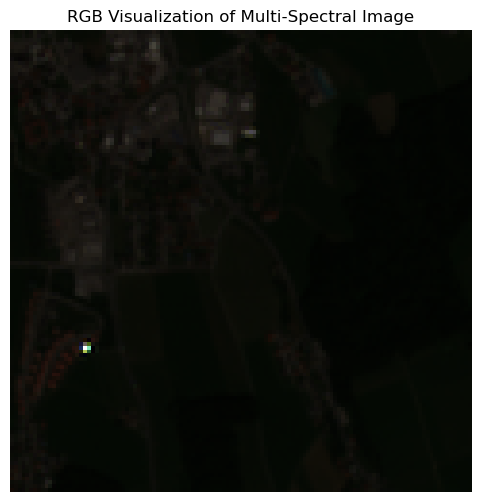

In [67]:
def show_rgb_from_batch(image_tensor, in_channels):
    image_cpu = image_tensor.detach().cpu().numpy()

    if in_channels == 12:
        red = image_cpu[3]
        green = image_cpu[2]
        blue = image_cpu[1]
    else:
        red = image_cpu[0]
        green = image_cpu[1]
        blue = image_cpu[2]

    red = (red - red.min()) / (red.max() - red.min() + 1e-8)
    green = (green - green.min()) / (green.max() - green.min() + 1e-8)
    blue = (blue - blue.min()) / (blue.max() - blue.min() + 1e-8)

    # Stack into an RGB image
    rgb_image = np.stack([red, green, blue], axis=-1)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.title("RGB Visualization of Multi-Spectral Image")
    plt.axis('off')
    plt.show()

data_module = BigEarthNetTIFDataModule(bands=bands, dataset_dir=dataset_dir, metadata_csv=metadata_csv)
data_module.setup(stage='test')

test_loader = data_module.val_dataloader()
example_batch = next(iter(test_loader))
example_imgs, example_lbls = example_batch

in_channels = len(bands)
show_rgb_from_batch(example_imgs[0], in_channels)

Patch ID: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67, Retrieved Labels: ['Arable land' 'Complex cultivation patterns' 'Inland wetlands'
 'Mixed forest' 'Pastures']
Parsed Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67: ['Arable land', 'Complex cultivation patterns', 'Inland wetlands', 'Mixed forest', 'Pastures']
Encoded Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_37_67: tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0.])
Patch ID: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_60_56, Retrieved Labels: ['Arable land' 'Complex cultivation patterns' 'Mixed forest' 'Pastures']
Parsed Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_60_56: ['Arable land', 'Complex cultivation patterns', 'Mixed forest', 'Pastures']
Encoded Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_60_56: tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0.])


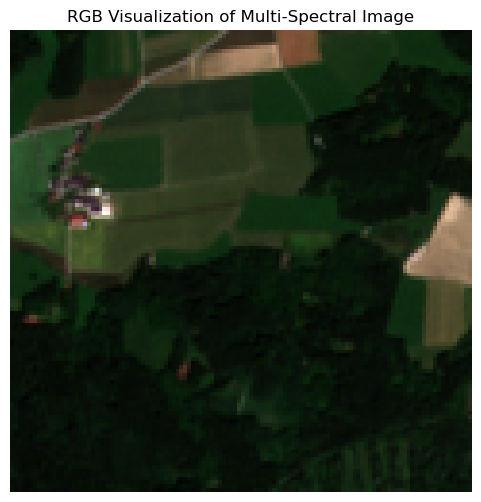

In [61]:
def show_rgb_from_batch(image_tensor, in_channels):
    image_cpu = image_tensor.detach().cpu().numpy()

    if in_channels == 12:
        red = image_cpu[3]
        green = image_cpu[2]
        blue = image_cpu[1]
    else:
        red = image_cpu[0]
        green = image_cpu[1]
        blue = image_cpu[2]

    red = (red - red.min()) / (red.max() - red.min() + 1e-8)
    green = (green - green.min()) / (green.max() - green.min() + 1e-8)
    blue = (blue - blue.min()) / (blue.max() - blue.min() + 1e-8)

    # Stack into an RGB image
    rgb_image = np.stack([red, green, blue], axis=-1)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.title("RGB Visualization of Multi-Spectral Image")
    plt.axis('off')
    plt.show()

data_module = BigEarthNetTIFDataModule(bands=bands, dataset_dir=dataset_dir, metadata_csv=metadata_csv)
data_module.setup(stage='test')

test_loader = data_module.test_dataloader()
example_batch = next(iter(test_loader))
example_imgs, example_lbls = example_batch

in_channels = len(bands)
show_rgb_from_batch(example_imgs[0], in_channels)